In [ ]:
import pandas as pd
import glob
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score


In [41]:
directory_hps = '../HPS'
os.chdir(directory_hps)
all_filenames_hps = glob.glob("*.csv")
combined_hps_df = pd.concat([pd.read_csv(f) for f in all_filenames_hps], ignore_index=True)
os.chdir('../')
combined_hps_df.to_csv("combined_hps.csv", index=False)

In [46]:
# Load your full dataset
df = pd.read_csv('combined_hps.csv', low_memory=False)

In [ ]:
# List of key factors
columns_needed = [
    'ANYWORK', 'KINDWORK', 'WRKLOSSRV', 'TWDAYS',               # Remote work & productivity
    'ANXIOUS', 'WORRY', 'INTEREST', 'DOWN',                     # Mental health indicators
    'EST_ST', 'REGION', 'RRACE', 'RHISPANIC',                   # Demographic: state/region/race/ethnicity
    'TBIRTH_YEAR', 'INCOME', 'EEDUC', 'MS',                     # Demographic: age, income, education, marital status
    'HLTHINS1', 'HLTHINS2',                                     # Organizational: health insurance
    'CHILDCARE',                                                # Organizational: childcare
    'EXPNS_DIF', 'PRICECHNG', 'PRICESTRESS',                    # Economic stressors
    'SUPPORT1', 'SUPPORT2',                                     # Social support
    'LONGCOVID', 'SYMPTOMS', 'SCRAM'                            # Health moderators and unique ID
]

# Make a new DataFrame with only selected columns
df_selected = df[columns_needed]

# Save it to a new CSV file
df_selected.to_csv('HPS_selected_columns.csv', index=False)

print("Relevant columns saved")


Relevant columns saved


In [ ]:
import pandas as pd
import numpy as np

# Sample data loading — replace with your actual CSV file path
data = pd.read_csv('HPS_selected_columns.csv')

# Replace special missing value codes (-88, -99) with NaN
missing_value_codes = [-88, -99]
data.replace(missing_value_codes, np.nan, inplace=True)

# Remove duplicate rows if any
data.drop_duplicates(inplace=True)

# Fix inconsistencies
# For categorical columns, convert categorical columns to 'category' dtype
categorical_columns = ['ANYWORK', 'KINDWORK', 'WRKLOSSRV', 'ANXIOUS', 'WORRY', 'INTEREST', 
                       'DOWN', 'EST_ST', 'REGION', 'RRACE', 'RHISPANIC', 'EEDUC', 'MS', 'HLTHINS1',
                       'HLTHINS2', 'CHILDCARE', 'EXPNS_DIF', 'PRICECHNG', 'PRICESTRESS', 'SUPPORT1',
                       'SUPPORT2', 'LONGCOVID', 'SYMPTOMS']

for col in categorical_columns:
  if col in data.columns:
    data[col] = data[col].astype('category')

# For numeric columns ensure the type is numeric
numeric_columns = ['TBIRTH_YEAR', 'INCOME', 'TWDAYS']

for col in numeric_columns:
  if col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# After cleaning, you can check how many missing values remain per column
missing_summary = data.isnull().sum()

print("Missing values per column:")
print(missing_summary)

# Save cleaned data if needed
data.to_csv('cleaned_dataset.csv', index=False)


Missing values per column:
ANYWORK         11963
KINDWORK       260185
WRKLOSSRV       10031
TWDAYS          17443
ANXIOUS         38324
WORRY           39270
INTEREST        39300
DOWN            39347
EST_ST              0
REGION              0
RRACE               0
RHISPANIC           0
TBIRTH_YEAR         0
INCOME         105090
EEDUC               0
MS               4878
HLTHINS1       109181
HLTHINS2       144108
CHILDCARE      448161
EXPNS_DIF       60210
PRICECHNG       56746
PRICESTRESS    178271
SUPPORT1        49526
SUPPORT2        49814
LONGCOVID      302946
SYMPTOMS       292625
SCRAM               0
dtype: int64


In [ ]:
import pandas as pd
import numpy as np

# Load your dataset
data = pd.read_csv('cleaned_dataset.csv')

# Replace empty strings and specific NA placeholders with np.nan, if any
data.replace(['', 'NA', 'NaN'], np.nan, inplace=True)

# Separate columns by type
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Impute numerical columns with median
for col in numerical_cols:
    if data[col].isnull().any():
        median_value = data[col].median()
        data[col].fillna(median_value, inplace=True)

# Impute categorical columns with mode
for col in categorical_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()
        if not mode_value.empty:
            data[col].fillna(mode_value[0], inplace=True)

# Check for remaining missing values
print(data.isnull().sum())

# Save cleaned data
data.to_csv('imputed_dataset.csv', index=False)


/var/folders/gk/m6_7mj810mq3yvqdk1_1j5qr0000gn/T/ipykernel_85641/2930811833.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_value, inplace=True)
/var/folders/gk/m6_7mj810mq3yvqdk1_1j5qr0000gn/T/ipykernel_85641/2930811833.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

ANYWORK        0
KINDWORK       0
WRKLOSSRV      0
TWDAYS         0
ANXIOUS        0
WORRY          0
INTEREST       0
DOWN           0
EST_ST         0
REGION         0
RRACE          0
RHISPANIC      0
TBIRTH_YEAR    0
INCOME         0
EEDUC          0
MS             0
HLTHINS1       0
HLTHINS2       0
CHILDCARE      0
EXPNS_DIF      0
PRICECHNG      0
PRICESTRESS    0
SUPPORT1       0
SUPPORT2       0
LONGCOVID      0
SYMPTOMS       0
SCRAM          0
dtype: int64


In [17]:
# Create AGE feature
imputed_data = pd.read_csv('imputed_dataset.csv')
CURRENT_YEAR = 2025
imputed_data['AGE'] = CURRENT_YEAR - imputed_data['TBIRTH_YEAR']
imputed_data.drop(columns=['TBIRTH_YEAR'], inplace=True)

In [15]:
print(imputed_data.head())

   ANYWORK  KINDWORK  WRKLOSSRV  TWDAYS  ANXIOUS  WORRY  INTEREST  DOWN  \
0      2.0       2.0        2.0     4.0      1.0    1.0       1.0   1.0   
1      2.0       2.0        2.0     4.0      1.0    1.0       1.0   1.0   
2      1.0       1.0        2.0     4.0      1.0    1.0       1.0   1.0   
3      1.0       2.0        2.0     4.0      1.0    1.0       1.0   1.0   
4      2.0       2.0        2.0     4.0      1.0    1.0       2.0   1.0   

   EST_ST  REGION  ...  CHILDCARE  EXPNS_DIF  PRICECHNG  PRICESTRESS  \
0      24       2  ...        2.0        1.0        1.0          4.0   
1      48       2  ...        2.0        1.0        2.0          2.0   
2      44       1  ...        2.0        1.0        1.0          3.0   
3       6       4  ...        2.0        2.0        1.0          2.0   
4      47       2  ...        2.0        1.0        1.0          3.0   

   SUPPORT1  SUPPORT2  LONGCOVID  SYMPTOMS       SCRAM  AGE  
0       2.0       2.0        3.0       3.0  P030000001

Statistical Summary:
              ANYWORK       KINDWORK      WRKLOSSRV         TWDAYS  \
count   610755.000000  610755.000000  610755.000000  610755.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         1.396059       2.156259       1.904142       3.431269   
std          0.489077       0.728685       0.294397       0.972193   
min          1.000000       1.000000       1.000000       1.000000   
25%          1.000000       2.000000       2.000000       3.000000   
50%          1.000000       2.000000       2.000000       4.000000   
75%          2.000000       2.000000       2.000000       4.000000   
max          2.000000       5.000000       2.000000       4.000000   

              ANXIOUS          WORRY       INTEREST           DOWN  \
count   610755.000000  610755.000000  610755.000000  610755.000000  

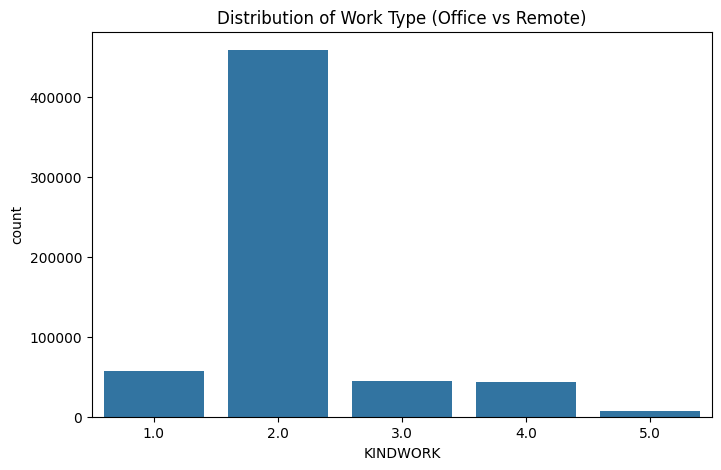

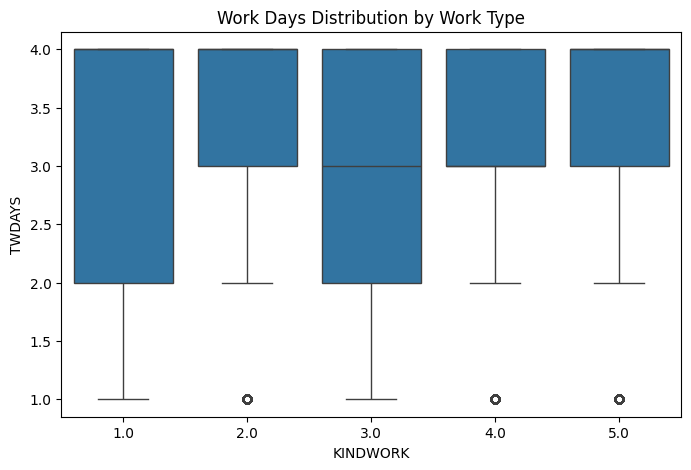

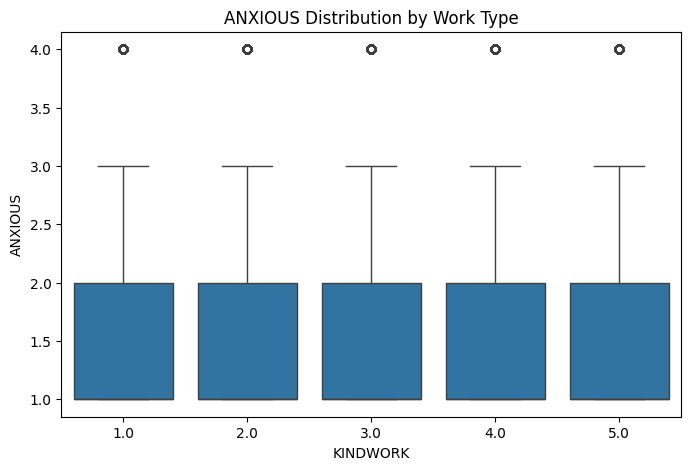

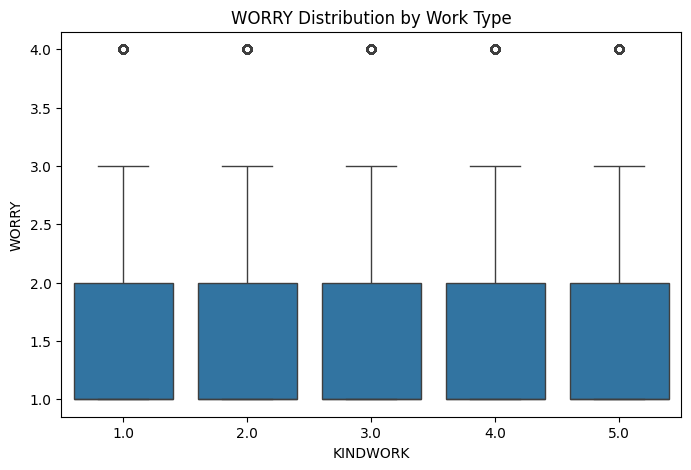

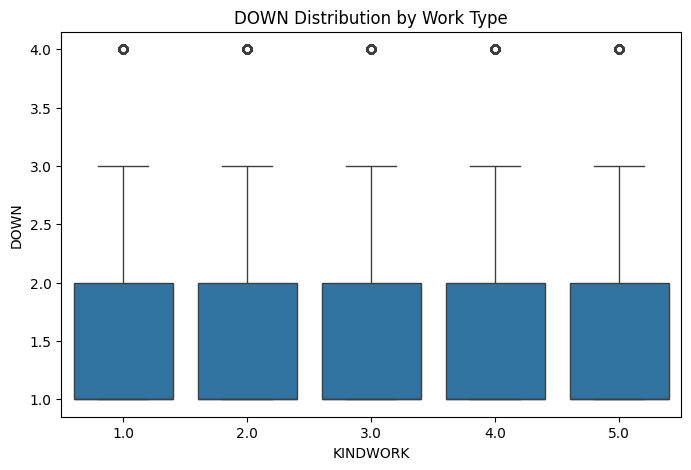

In [6]:
# Function to perform data exploration
def data_exploration(data):

    # Statistical summary
    summary_stats = data.describe(include='all')
    print("Statistical Summary:")
    print(summary_stats)
    
    # Visualize the distribution of work type
    plt.figure(figsize=(8,5))
    sns.countplot(data=data, x='KINDWORK')
    plt.title('Distribution of Work Type (Office vs Remote)')
    plt.show()
    
    # Visualize workdays distribution by KINDWORK as proxy for productivity
    plt.figure(figsize=(8,5))
    sns.boxplot(data=data, x='KINDWORK', y='TWDAYS')
    plt.title('Work Days Distribution by Work Type')
    plt.show()

    # Visualize key mental health metrics (ANXIOUS, WORRY, DOWN) by KINDWORK
    mental_health_metrics = ['ANXIOUS', 'WORRY', 'DOWN']
    for metric in mental_health_metrics:
        plt.figure(figsize=(8,5))
        sns.boxplot(data=data, x='KINDWORK', y=metric)
        plt.title(f'{metric} Distribution by Work Type')
        plt.show()


data_exploration(imputed_data)


In [ ]:
symptom_cols = ['ANXIOUS','WORRY','INTEREST','DOWN']
scaler = StandardScaler()
transformed_data =imputed_data
transformed_data[symptom_cols] = scaler.fit_transform(transformed_data[symptom_cols])
transformed_data['MENTAL_HEALTH'] = transformed_data[symptom_cols].mean(axis=1)

transformed_data = transformed_data.drop(columns=symptom_cols)

# Create productivity proxy as inverse of WRKLOSSRV if relevant (example)
transformed_data['PRODUCTIVITY'] = 1 - transformed_data['WRKLOSSRV']

transformed_data = transformed_data.drop(columns=['WRKLOSSRV'])

transformed_data.head()


,ANYWORK,KINDWORK,TWDAYS,EST_ST,REGION,RRACE,RHISPANIC,INCOME,EEDUC,MS,...,PRICECHNG,PRICESTRESS,SUPPORT1,SUPPORT2,LONGCOVID,SYMPTOMS,SCRAM,AGE,MENTAL_HEALTH,PRODUCTIVITY
0,2.0,2.0,4.0,24,2,1,1,6.0,6,1.0,...,1.0,4.0,2.0,2.0,3.0,3.0,P030000001,81,-0.594775,-1.0
1,2.0,2.0,4.0,48,2,1,1,1.0,4,2.0,...,2.0,2.0,1.0,2.0,3.0,3.0,P030000002,70,-0.594775,-1.0
2,1.0,1.0,4.0,44,1,1,1,7.0,5,1.0,...,1.0,3.0,1.0,2.0,2.0,2.0,P030000003,39,-0.594775,-1.0
3,1.0,2.0,4.0,6,4,1,2,5.0,3,1.0,...,1.0,2.0,2.0,1.0,3.0,3.0,P030000004,42,-0.594775,-1.0
4,2.0,2.0,4.0,47,2,1,1,1.0,4,1.0,...,1.0,3.0,4.0,2.0,2.0,2.0,P030000005,85,-0.263998,-1.0


In [30]:
def correlation_categorical_numerical(data):
    # Identify categorical columns (object or category dtype)
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # One-hot encode categorical columns
    data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    
    # Compute correlation matrix on encoded + numerical data
    corr_matrix = data_encoded.corr()
    
    print("Correlation matrix including numerical and one-hot encoded categorical vars:")
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of ' + ', '.join(data.columns) + ' Variables')
    plt.show()

Correlation matrix including numerical and one-hot encoded categorical vars:


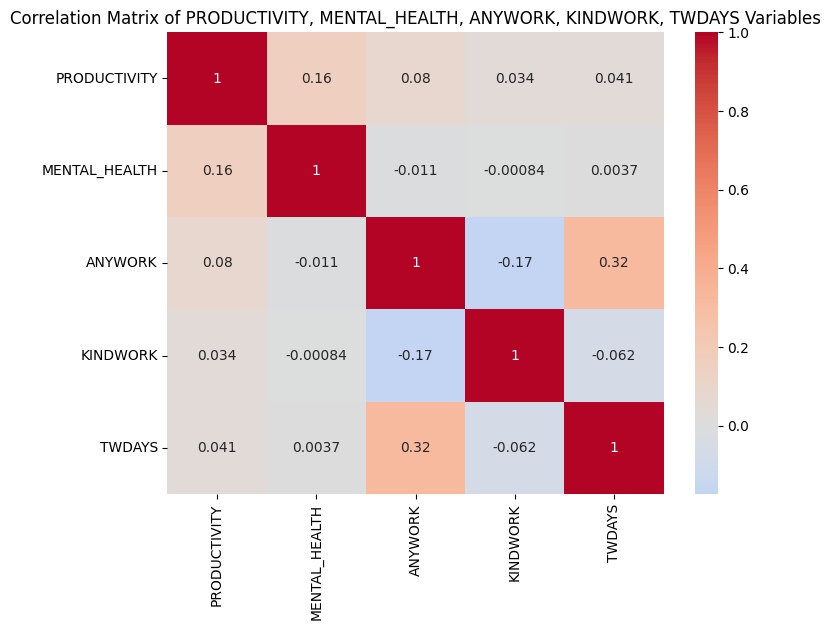

In [31]:
correlation_categorical_numerical(transformed_data[['PRODUCTIVITY', 'MENTAL_HEALTH','ANYWORK', 'KINDWORK','TWDAYS']])

Correlation matrix including numerical and one-hot encoded categorical vars:


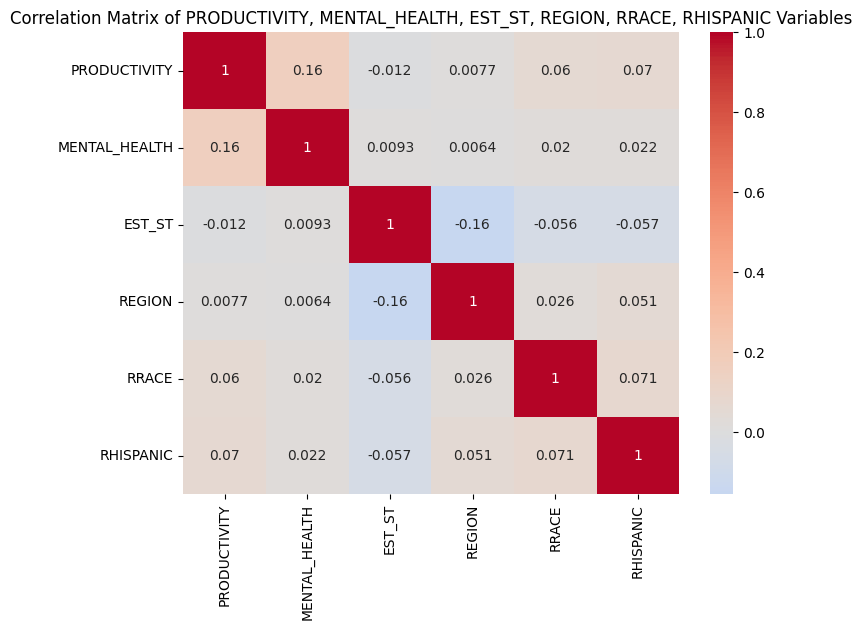

In [33]:
correlation_categorical_numerical(transformed_data[['PRODUCTIVITY', 'MENTAL_HEALTH','EST_ST', 'REGION', 'RRACE', 'RHISPANIC']])

Correlation matrix including numerical and one-hot encoded categorical vars:


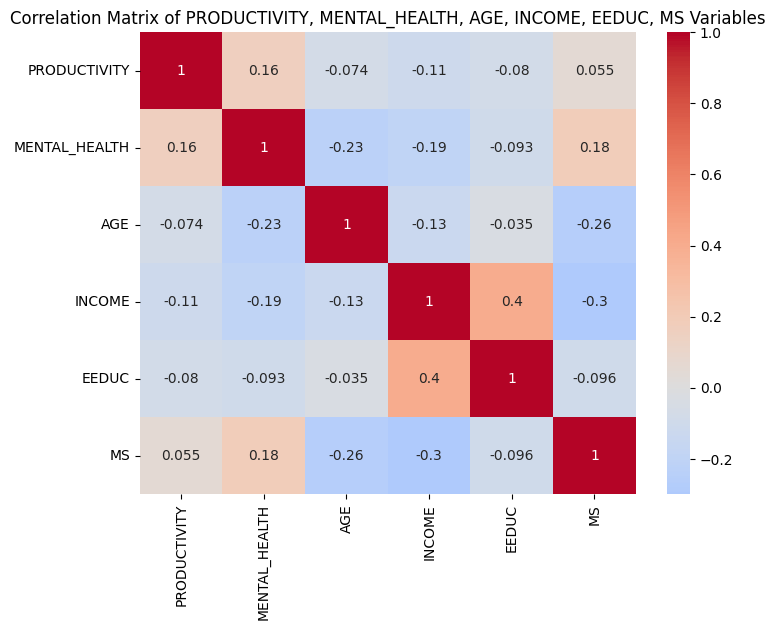

In [34]:
correlation_categorical_numerical(transformed_data[['PRODUCTIVITY', 'MENTAL_HEALTH','AGE', 'INCOME', 'EEDUC', 'MS']])

Correlation matrix including numerical and one-hot encoded categorical vars:


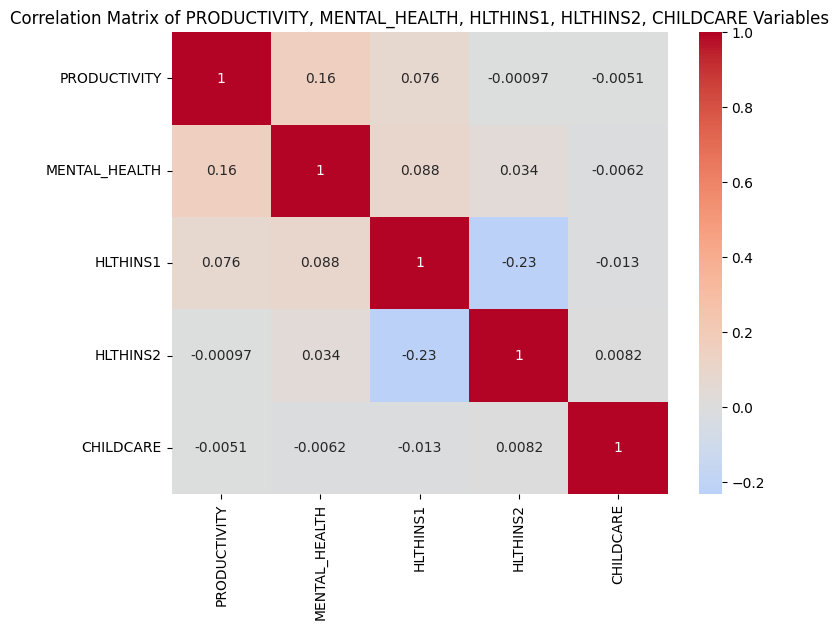

In [35]:
correlation_categorical_numerical(transformed_data[['PRODUCTIVITY', 'MENTAL_HEALTH','HLTHINS1', 'HLTHINS2','CHILDCARE']])

Correlation matrix including numerical and one-hot encoded categorical vars:


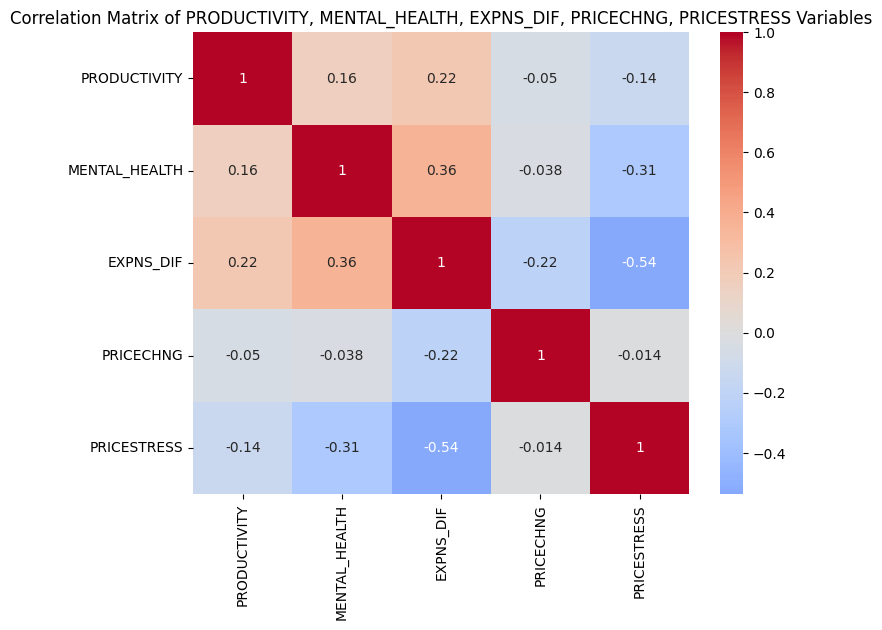

In [36]:
correlation_categorical_numerical(transformed_data[['PRODUCTIVITY', 'MENTAL_HEALTH','EXPNS_DIF', 'PRICECHNG', 'PRICESTRESS']])

Correlation matrix including numerical and one-hot encoded categorical vars:


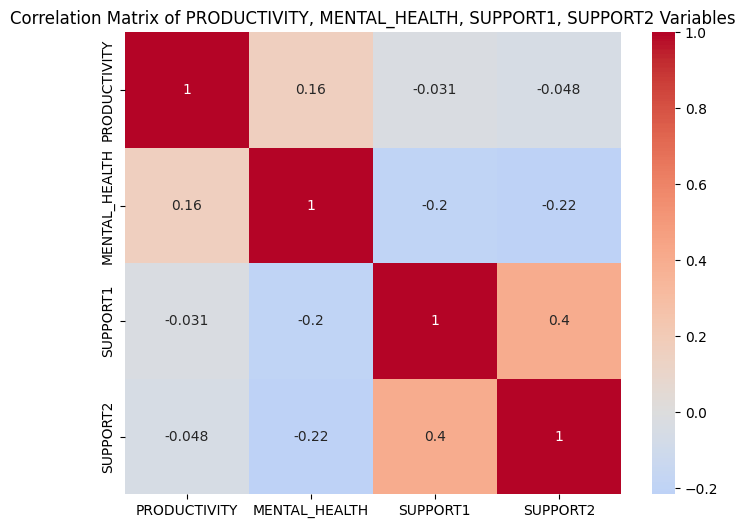

In [37]:
correlation_categorical_numerical(transformed_data[['PRODUCTIVITY', 'MENTAL_HEALTH','SUPPORT1', 'SUPPORT2']])

Correlation matrix including numerical and one-hot encoded categorical vars:


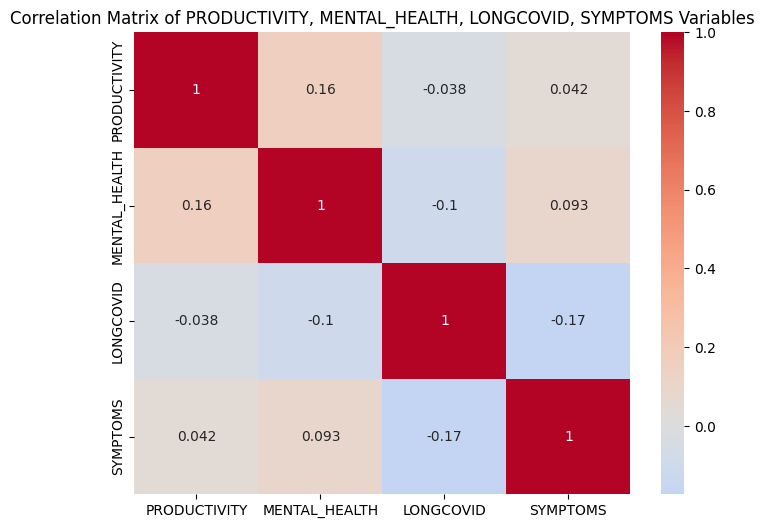

In [38]:
correlation_categorical_numerical(transformed_data[['PRODUCTIVITY', 'MENTAL_HEALTH','LONGCOVID', 'SYMPTOMS']])

In [43]:
# Load dataset and select columns
selected_features = [
    'ANYWORK', 'KINDWORK', 'TWDAYS',
    'REGION', 'EST_ST', 'RRACE', 'AGE', 'INCOME', 'EEDUC',
    'SUPPORT1', 'SUPPORT2', 'LONGCOVID', 'SYMPTOMS',
    'PRODUCTIVITY', 'MENTAL_HEALTH'
]

selected_data = transformed_data[selected_features]

# Prepare predictors (X) and targets (Y)
X = selected_data.drop(['PRODUCTIVITY', 'MENTAL_HEALTH'], axis=1)
y_prod = selected_data['PRODUCTIVITY']
y_mh = selected_data['MENTAL_HEALTH']

# Encode categoricals for regression
X = pd.get_dummies(X, drop_first=True)

# Train/validation/test splits (70/15/15)
X_train, X_temp, y_prod_train, y_prod_temp, y_mh_train, y_mh_temp = train_test_split(
    X, y_prod, y_mh, test_size=0.3, random_state=42
)
X_val, X_test, y_prod_val, y_prod_test, y_mh_val, y_mh_test = train_test_split(
    X_temp, y_prod_temp, y_mh_temp, test_size=0.5, random_state=42
)

# Train two separate multiple regression models
lr_prod = LinearRegression()
lr_prod.fit(X_train, y_prod_train)

lr_mh = LinearRegression()
lr_mh.fit(X_train, y_mh_train)

# Validation performance (can tune using results)
val_prod_pred = lr_prod.predict(X_val)
val_mh_pred = lr_mh.predict(X_val)

print("Validation (PRODUCTIVITY): R2 =", r2_score(y_prod_val, val_prod_pred), 
      "RMSE =", root_mean_squared_error(y_prod_val, val_prod_pred))
print("Validation (MENTAL HEALTH): R2 =", r2_score(y_mh_val, val_mh_pred), 
      "RMSE =", root_mean_squared_error(y_mh_val, val_mh_pred))

# Final test evaluation
test_prod_pred = lr_prod.predict(X_test)
test_mh_pred = lr_mh.predict(X_test)

print("Test (PRODUCTIVITY): R2 =", r2_score(y_prod_test, test_prod_pred), 
      "RMSE =", root_mean_squared_error(y_prod_test, test_prod_pred))
print("Test (MENTAL HEALTH): R2 =", r2_score(y_mh_test, test_mh_pred), 
      "RMSE =", root_mean_squared_error(y_mh_test, test_mh_pred))


Validation (PRODUCTIVITY): R2 = 0.03977108537308738 RMSE = 0.28769056849017166
Validation (MENTAL HEALTH): R2 = 0.16012634969870432 RMSE = 0.8059617823083423
Test (PRODUCTIVITY): R2 = 0.038622181442196646 RMSE = 0.2876250059706501
Test (MENTAL HEALTH): R2 = 0.1613443296298248 RMSE = 0.8108422846075174
